In [23]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [24]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [25]:
def preprocess_text(text):
    # Tokenization
    words = word_tokenize(text)

    # Removing stop words
    stop_words = set(stopwords.words('english'))
    words = [word.lower() for word in words if word.isalnum() and word.lower() not in stop_words]

    # Stemming
    stemmer = PorterStemmer()
    words = [stemmer.stem(word) for word in words]

    return ' '.join(words)

In [26]:
# Connect to the SQLite database
database_path = r'C:\Users\Admin\Desktop\database.sqlite'
connection = sqlite3.connect(database_path)

# Read a table into a DataFrame
query = f"SELECT * FROM 'Tweets';"
df = pd.read_sql_query(query, connection)

In [27]:
df.shape

(14485, 15)

In [28]:
df['airline_sentiment'].value_counts()

negative    9082
neutral     3069
positive    2334
Name: airline_sentiment, dtype: int64

In [29]:
df

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,567588278875213824,neutral,1.0000,,,Delta,,JetBlueNews,,0,@JetBlue's new CEO seeks the right balance to ...,,2015-02-16 23:36:05 -0800,USA,Sydney
1,567590027375702016,negative,1.0000,Can't Tell,0.6503,Delta,,nesi_1992,,0,@JetBlue is REALLY getting on my nerves !! 😡😡 ...,,2015-02-16 23:43:02 -0800,undecided,Pacific Time (US & Canada)
2,567591480085463040,negative,1.0000,Late Flight,0.346,United,,CPoutloud,,0,@united yes. We waited in line for almost an h...,,2015-02-16 23:48:48 -0800,"Washington, DC",
3,567592368451248130,negative,1.0000,Late Flight,1,United,,brenduch,,0,@united the we got into the gate at IAH on tim...,,2015-02-16 23:52:20 -0800,,Buenos Aires
4,567594449874587648,negative,1.0000,Customer Service Issue,0.3451,Southwest,,VahidESQ,,0,@SouthwestAir its cool that my bags take a bit...,,2015-02-17 00:00:36 -0800,"Los Angeles, CA",Pacific Time (US & Canada)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14480,570309308937842688,neutral,0.6869,,,Delta,,Oneladyyouadore,,0,@JetBlue I hope so because I fly very often an...,,2015-02-24 11:48:29 -0800,Georgia,Quito
14481,570309340952993796,neutral,1.0000,,,US Airways,,DebbiMcGinnis,,0,@USAirways is a DM possible if you aren't foll...,,2015-02-24 11:48:37 -0800,Missourah,Hawaii
14482,570309345281486848,positive,0.6469,,,Delta,,jaxbra,,0,@JetBlue Yesterday on my way from EWR to FLL j...,,2015-02-24 11:48:38 -0800,"east brunswick, nj",Atlantic Time (Canada)
14483,570310144459972608,negative,1.0000,Customer Service Issue,1,US Airways,,GAKotsch,,0,@USAirways and when will one of these agents b...,,2015-02-24 11:51:48 -0800,,Atlantic Time (Canada)


In [30]:
tweet=df['airline'].value_counts()

In [31]:
print(tweet)

United            3822
US Airways        2913
American          2604
Southwest         2420
Delta             2222
Virgin America     504
Name: airline, dtype: int64


In [32]:
neg_tweet=df[df['airline_sentiment'] == 'negative'].groupby('airline')['airline'].count()

In [33]:
print(neg_tweet)

airline
American          1864
Delta              955
Southwest         1186
US Airways        2263
United            2633
Virgin America     181
Name: airline, dtype: int64


In [34]:
neg_perc=neg_tweet/tweet*100

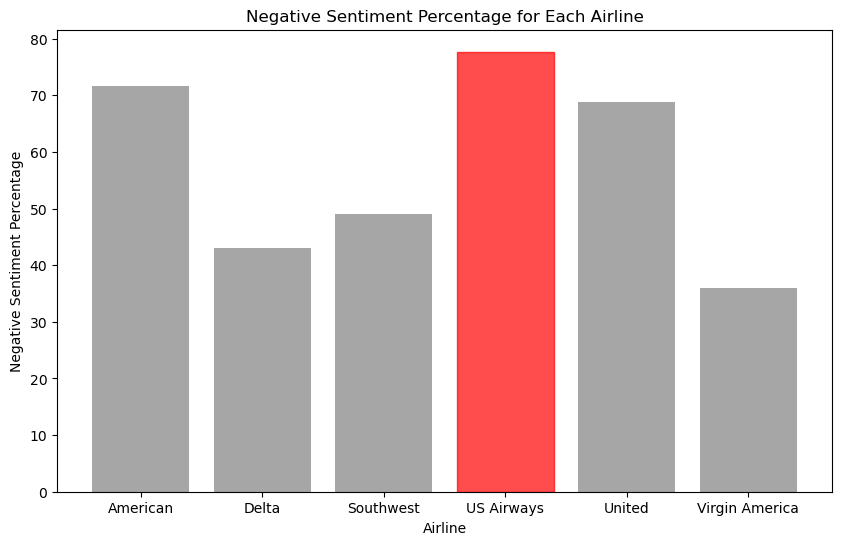

In [35]:
plt.figure(figsize=(10, 6))
bars = plt.bar(neg_perc.index, neg_perc, color='grey', alpha=0.7)

# Find the index of the highest negative sentiment percentage
max_index = neg_perc.idxmax()

# Highlight the highest bar in red
for bar in bars:
    if bar.get_height() == neg_perc[max_index]:
        bar.set_color('red')

# Set plot labels and title
plt.xlabel('Airline')
plt.ylabel('Negative Sentiment Percentage')
plt.title('Negative Sentiment Percentage for Each Airline')

# Show the plot
plt.show()

In [36]:
df[df['airline']=='US Airways']['negativereason'].value_counts()

Customer Service Issue         811
                               650
Late Flight                    453
Can't Tell                     246
Cancelled Flight               189
Lost Luggage                   154
Flight Attendant Complaints    123
Flight Booking Problems        122
Bad Flight                     104
longlines                       50
Damaged Luggage                 11
Name: negativereason, dtype: int64

In [37]:
# Checking for empty rows
empty_rows_count = df['text'].isnull().sum() + (df['text'] == '').sum()

print("Number of empty rows in 'negativereason' column:", empty_rows_count)

Number of empty rows in 'negativereason' column: 0


In [38]:
# Assuming 'text' is the column containing the tweet text
df['preprocessed_text'] = df['text'].apply(preprocess_text)

In [39]:
# Split the dataset into training and testing sets
X=df['text']
y=df['airline_sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Use CountVectorizer on the preprocessed text
vectorizer = CountVectorizer(stop_words='english')
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

In [40]:
# Use a simple model (Naive Bayes in this example)
model = MultinomialNB()
model.fit(X_train_vectorized, y_train)

MultinomialNB()

In [41]:
y_pred = model.predict(X_test_vectorized)

In [42]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Confusion Matrix:\n{conf_matrix}')
print(f'Classification Report:\n{class_report}')

Accuracy: 0.7431826026924404
Confusion Matrix:
[[1698   60   25]
 [ 371  212   40]
 [ 206   42  243]]
Classification Report:
              precision    recall  f1-score   support

    negative       0.75      0.95      0.84      1783
     neutral       0.68      0.34      0.45       623
    positive       0.79      0.49      0.61       491

    accuracy                           0.74      2897
   macro avg       0.74      0.60      0.63      2897
weighted avg       0.74      0.74      0.72      2897



In [43]:
df['preprocessed_text'] = df['text'].apply(preprocess_text)

# Features and labels
X = df['preprocessed_text']
y = df['airline_sentiment']

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Vectorize the text data
vectorizer = CountVectorizer(stop_words='english')
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

# Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_vectorized, y_train)
rf_pred = rf_model.predict(X_test_vectorized)

# Evaluate Random Forest
print("Random Forest Results:")
print(f'Accuracy: {accuracy_score(y_test, rf_pred)}')
print(f'Confusion Matrix:\n{confusion_matrix(y_test, rf_pred)}')
print(f'Classification Report:\n{classification_report(y_test, rf_pred)}')

Random Forest Results:
Accuracy: 0.7473248187780462
Confusion Matrix:
[[1602  135   46]
 [ 289  276   58]
 [ 143   61  287]]
Classification Report:
              precision    recall  f1-score   support

    negative       0.79      0.90      0.84      1783
     neutral       0.58      0.44      0.50       623
    positive       0.73      0.58      0.65       491

    accuracy                           0.75      2897
   macro avg       0.70      0.64      0.66      2897
weighted avg       0.73      0.75      0.74      2897



In [55]:
# Features and labels
X = df['preprocessed_text']
y = df['airline_sentiment']

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Vectorize the text data
vectorizer = CountVectorizer(stop_words='english')
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

# SVM Classifier
svm_model = SVC(kernel='linear', C=1, random_state=42)
svm_model.fit(X_train_vectorized, y_train)
svm_pred = svm_model.predict(X_test_vectorized)

# Evaluate SVM
print("\nSVM Results:")
print(f'Accuracy: {accuracy_score(y_test, svm_pred)}')
print(f'Confusion Matrix:\n{confusion_matrix(y_test, svm_pred)}')
print(f'Classification Report:\n{classification_report(y_test, svm_pred)}')


SVM Results:
Accuracy: 0.7566448049706593
Confusion Matrix:
[[1537  178   68]
 [ 225  333   65]
 [  97   72  322]]
Classification Report:
              precision    recall  f1-score   support

    negative       0.83      0.86      0.84      1783
     neutral       0.57      0.53      0.55       623
    positive       0.71      0.66      0.68       491

    accuracy                           0.76      2897
   macro avg       0.70      0.68      0.69      2897
weighted avg       0.75      0.76      0.75      2897

